# Music recommendation

## Task 2

importing libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import string
import math
import missingno as msno
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px
%matplotlib inline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb

In [3]:
songs_df = pd.read_csv("songs.csv")
songs_extra_df = pd.read_csv("song_extra_info.csv")
members_df = pd.read_csv("members.csv")
train_df = pd.read_csv("train.csv", nrows = 100000)
t_s = pd.merge(train_df, songs_df, on='song_id', how='left')
t_s_se = pd.merge(t_s, songs_extra_df, on='song_id', how='left')
songs = pd.merge(t_s_se, members_df, on='msno', how='left')
del songs_df, songs_extra_df, members_df, train_df, t_s, t_s_se

songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,7,20120102,20171005


In [4]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23372 entries, 0 to 23371
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   msno                    23372 non-null  object 
 1   song_id                 23372 non-null  object 
 2   source_system_tab       23295 non-null  object 
 3   source_screen_name      22650 non-null  object 
 4   source_type             23315 non-null  object 
 5   target                  23371 non-null  float64
 6   song_length             2775 non-null   float64
 7   genre_ids               2723 non-null   object 
 8   artist_name             2775 non-null   object 
 9   composer                2181 non-null   object 
 10  lyricist                1716 non-null   object 
 11  language                2775 non-null   float64
 12  name                    1934 non-null   object 
 13  isrc                    1746 non-null   object 
 14  city                    23372 non-null

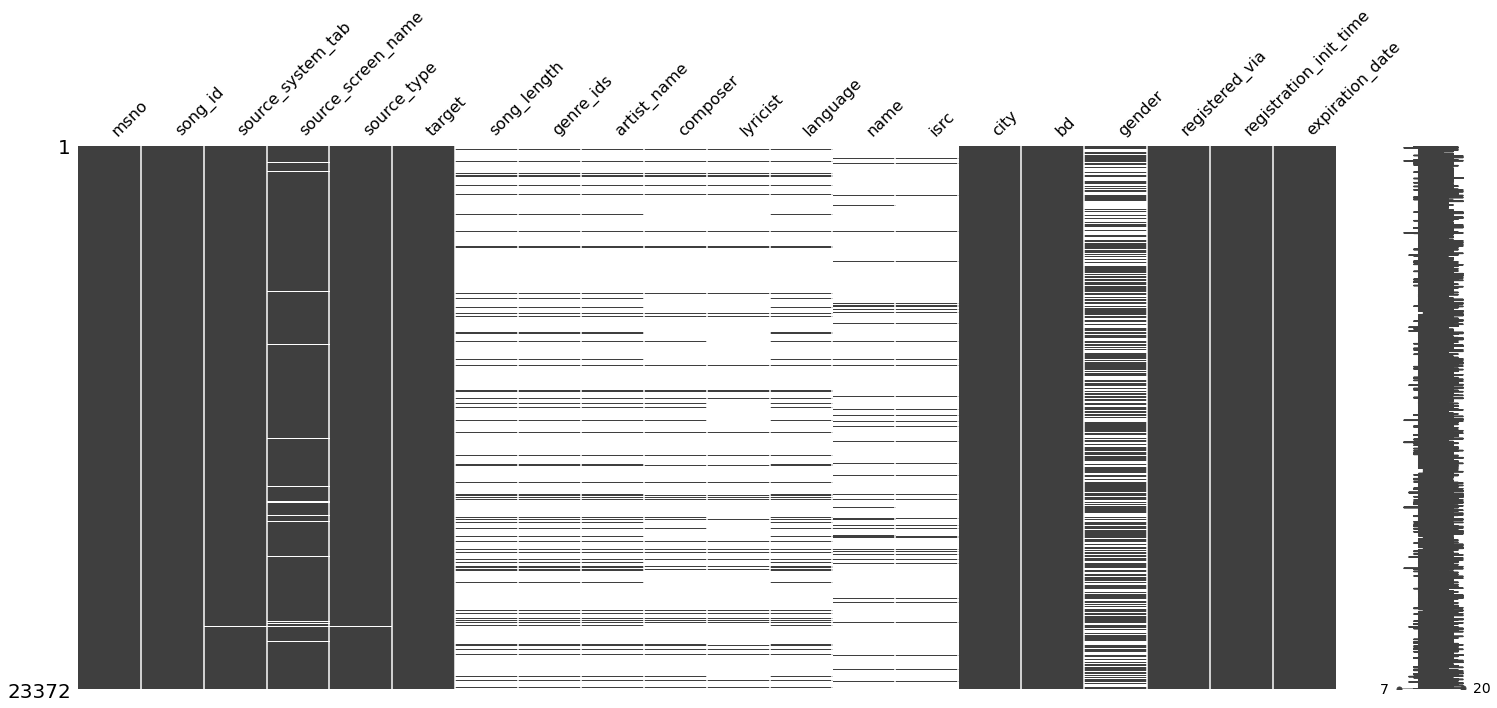

In [5]:
msno.matrix(songs)

In [6]:
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs = songs.fillna(value=0)

In [7]:
songs.registration_init_time = pd.to_datetime(songs.registration_init_time, format='%Y%m%d', errors='ignore')
songs['registration_init_time_year'] = songs['registration_init_time'].dt.year
songs['registration_init_time_month'] = songs['registration_init_time'].dt.month
songs['registration_init_time_day'] = songs['registration_init_time'].dt.day

songs.expiration_date = pd.to_datetime(songs.expiration_date,  format='%Y%m%d', errors='ignore')
songs['expiration_date_year'] = songs['expiration_date'].dt.year
songs['expiration_date_month'] = songs['expiration_date'].dt.month
songs['expiration_date_day'] = songs['expiration_date'].dt.day

In [8]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0,0.0,unknown,unknown,unknown,unknown,0.0,unknown,unknown,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0,0.0,unknown,unknown,unknown,unknown,0.0,unknown,unknown,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0,0.0,unknown,unknown,unknown,unknown,0.0,unknown,unknown,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0,0.0,unknown,unknown,unknown,unknown,0.0,unknown,unknown,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0,0.0,unknown,unknown,unknown,unknown,0.0,unknown,unknown,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


In [9]:
label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in songs.columns :
    songs[i] = label_encoder.fit_transform(songs[i])

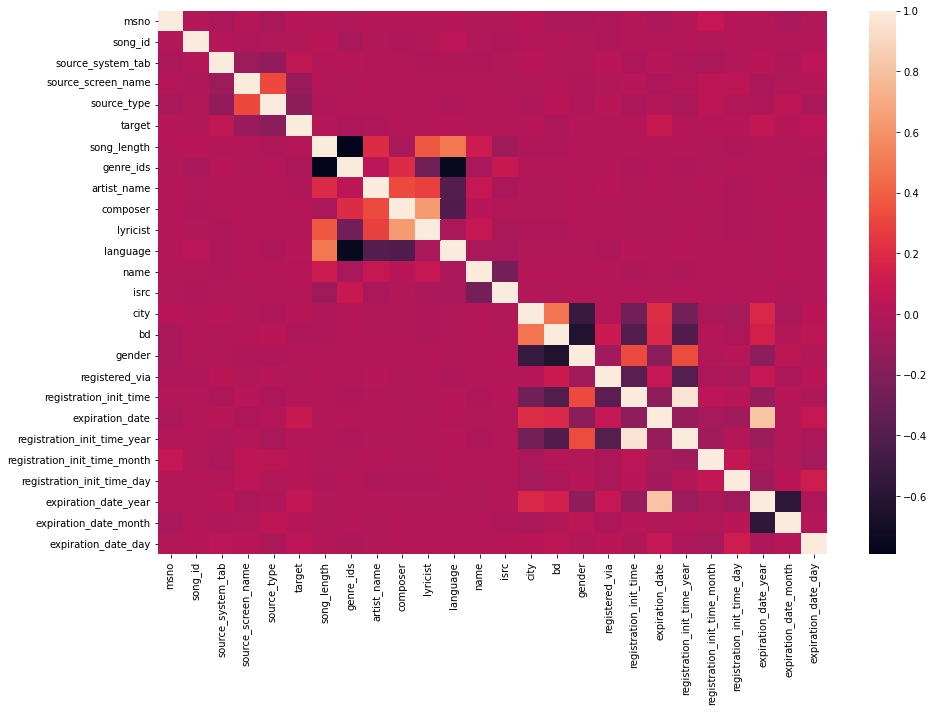

In [10]:
plt.figure(figsize=[15,10])
sns.heatmap(songs.corr())
plt.show()

In [11]:
# MODELING

X = songs.drop('target', axis = 1)
y = songs.target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [14]:

def model_with(model_name, X_train, X_val, y_train, y_val) :
    print("==================================================")
    print("Modeling with :", model_name)
    print()
        
    if model_name == "Random Forest Classifier" :
        model = RandomForestClassifier(
            n_estimators=1000, 
        )
    elif model_name == "Extra Trees Classifier" :
        model = ExtraTreesClassifier(
            n_estimators=1000,
        )
    elif model_name == "XGBoost Classifier" :
        model = xgb.XGBClassifier(
            n_estimators=1000, 
        )
    else :
        print("Model not found in function.")
        
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)
    print(classification_report(y_val, val_pred))
    print()
    print("Accuracy :", accuracy_score(y_val, val_pred))
    print("ROC :", roc_auc_score(y_val, val_pred))
    
    print("==================================================")
    print()
    

In [15]:
models = ["Random Forest Classifier", "Extra Trees Classifier", "XGBoost Classifier"]
for i in models :
    model_with(i, X_train, X_val, y_train, y_val)

Modeling with : Random Forest Classifier

              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1431
           1       0.87      0.90      0.88      4412

    accuracy                           0.82      5843
   macro avg       0.76      0.74      0.75      5843
weighted avg       0.82      0.82      0.82      5843


Accuracy : 0.8225226767071709
ROC : 0.7439013921121039

Modeling with : Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.64      0.60      0.62      1431
           1       0.87      0.89      0.88      4412

    accuracy                           0.82      5843
   macro avg       0.76      0.74      0.75      5843
weighted avg       0.82      0.82      0.82      5843


Accuracy : 0.8202977922300189
ROC : 0.7443167671169347

Modeling with : XGBoost Classifier

              precision    recall  f1-score   support

           0       0.76      0.45      0.57      1431
     